In [1]:
import pandas as pd
import numpy as np
import bbi
from gffutils.helpers import asinterval
from gtfparse import read_gtf
import bioframe as bf

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import StrMethodFormatter

# Flexible heatmap functions

This notebook is for writing out more flexible, modular functions for generating plots to represent ChIP signal over some interval.



In [3]:
# Uses pybbi to measure signal over set of input
def generate_signal_matrix(chip_seq_file, interval_chrom, interval_start, interval_end, windowSize, windowType, nbins):
    
    if windowType == 'extend':
        interval_start = interval_start - windowSize
        interval_end = interval_end + windowSize
        
    if windowType == 'centered':
        interval_start = (interval_start + interval_end)/2 - windowSize
        interval_end = (interval_start + interval_end)/2 + windowSize
    
    with bbi.open(chip_seq_file) as f:
        matrix = f.stackup(interval_chrom, interval_start, interval_end, bins=nbins)
        
    return matrix

In [4]:
def plot_avg_signal(DE_results_df, stackup_matrix, title, ax=None, DE_value_col='log2Fold_Change', cutoff='padj', cutoff_val=0.05, 
                    agg_key='DE_status', agg_categories=['up', 'down', 'nonsig'], color_categories=['r', 'b', 'k'], windowSize=1000, nbins=40):
    
    if ax == None:
        ax = plt.subplot()
    
    for category, color in zip(agg_categories, color_categories):
        
        cat_ix = np.where(DE_results_df[agg_key] == category)
        cat_matrix = stackup_matrix[cat_ix]
        
        ax.plot(np.nanmean(cat_matrix, axis=0), color = color, label=category)
        
    ax.set(xticks=np.arange(0, nbins+1, 10),
    xticklabels=(np.arange(0, (windowSize*2)+1, (windowSize/2))-(windowSize*2)//2),
    xlabel='Distance from boundary (bp)',
    ylabel='ChIP-Seq mean fold change over input')
    ax.set_title(title)

In [93]:
# Note: todo: DE_value_col='log2FoldChange', sort_by_DE=True ==> collect into sort_by_col = 'log2FoldChange'

## todo: do heatmap for DE_values in a separate function (like originally outlined) ** this can be less flexible/specific to diverging up_vs_down and maybe other color/heatmaps can have their own functions for other types of categories
def plot_binned_signal_heatmap(DE_results_df, stackup_matrix, title, ax=None, DE_value_col='log2FoldChange', sort_by_DE=True, agg_key='DE_status', agg_categories=['up', 'down'], include_category_map=True, color_categories=['r', 'b'], windowSize=1000, nbins=40):
    
    # if include_category_map --> change dimensions here
    if ax == None:
        if include_category_map:
            fig,ax=plt.subplots(1,2)
        else:
            ax = plt.subplot()
        
        
    # build the heatmap matrices 
    ordered_heatmap = []
    ordered_values = []
        
    # rearrange the matrix for plotting everything together
    for cat in agg_categories:
        
        # get first category
        cat_ix = np.where(DE_results_df[agg_key] == cat)
        sub_matrix = stackup_matrix[cat_ix]
        sub_results = DE_results_df.iloc[cat_ix]
        
        # if sort_by_DE
        # sort according to DE_value in descending order
        ordering = (-sub_results[DE_value_col]).argsort()
        ordered_heatmap.append(sub_matrix[ordering])
        ordered_values.append(sub_results.iloc[ordering][DE_value_col])

        
        
    #logFPKM = np.transpose(np.expand_dims(sig_DE['log2FoldChange'], axis=0))
    #ax.imshow(np.vstack(ordered_heatmap), cmap='gray_r', aspect='auto', vmin=0, vmax=100)
    
    if include_category_map:
        
        # collecting the set of DE values and normalizing for plotting
        change_vals = np.transpose(np.expand_dims(np.concatenate(ordered_values), axis=0))
        minval=np.min(change_vals)
        maxval=np.max(change_vals)
        
        divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
        hotcoldmap = plt.cm.get_cmap('RdBu').reversed()
        occ = ax[0].imshow(change_vals, cmap=hotcoldmap, norm=divnorm, aspect='auto')
        
        cbar = ax[0].figure.colorbar(occ, ax=ax[0], extend='max', location='left')
        
        ax[1].imshow(np.vstack(ordered_heatmap), cmap='gray_r', aspect='auto', vmin=0, vmax=100)    
        ax[1].set(xticks=np.arange(0, nbins+1, 10),
        xticklabels=(np.arange(0, (windowSize*2)+1, (windowSize/2))-(windowSize*2)//2),
        xlabel='Distance from boundary (bp)')
        ax[1].set_title(title)
        
    else:
        
        ax.imshow(np.vstack(ordered_heatmap), cmap='gray_r', aspect='auto', vmin=0, vmax=100)
        ax.set(xticks=np.arange(0, nbins+1, 10),
        xticklabels=(np.arange(0, (windowSize*2)+1, (windowSize/2))-(windowSize*2)//2),
        xlabel='Distance from boundary (bp)')
        ax.set_title(title)
        
        

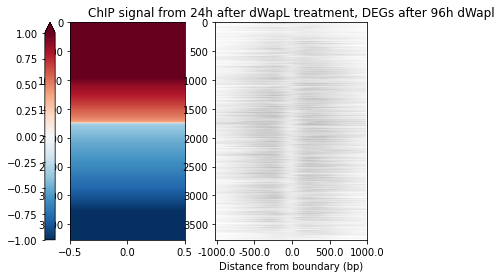

In [94]:
plot_binned_signal_heatmap(DE_result_df, 
                           matrix, 
                           'ChIP signal from 24h after dWapL treatment, DEGs after 96h dWapl',
                           sort_by_DE=True, 
                           agg_key='DE_status', 
                           agg_categories=['up', 'down'],
                           include_category_map=True,
                           color_categories=['r', 'b'])


### Testing argsort

I want to sort sets of genes (e.g. up/down/nonreg) based on their shared indices between the stackup matrix and the DE table. Making sure argsort is performing as expected:

In [28]:
small = DE_result_df.head(20)

In [29]:
small

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id,chrom,start,end,DE_status
29582.0,1929.145607,-0.165139,0.126582,-1.304600,1.920290e-01,3.598572e-01,ENSMUSG00000000001,chr3,108146147.0,108146147.0,nonsig
121961.0,774.525472,-0.609255,0.176577,-3.450373,5.598115e-04,3.509050e-03,ENSMUSG00000000028,chr16,18811973.0,18811973.0,down
68469.0,5.653012,0.144469,1.513693,0.095441,9.239644e-01,NaN,ENSMUSG00000000031,chr7,142578144.0,142578144.0,nonsig
24410.0,18.294264,0.969905,0.905673,1.070922,2.842043e-01,4.709056e-01,ENSMUSG00000000037,chrX,161082524.0,161082524.0,nonsig
104531.0,446.399420,0.663375,0.234989,2.823002,4.757631e-03,2.086583e-02,ENSMUSG00000000056,chr11,121237252.0,121237252.0,up
48765.0,0.959029,3.321625,4.029984,0.824228,4.098100e-01,NaN,ENSMUSG00000000058,chr6,17281184.0,17281184.0,nonsig
104720.0,812.764430,0.222758,0.163974,1.358492,1.743076e-01,3.372668e-01,ENSMUSG00000000078,chr13,5861481.0,5861481.0,nonsig
36139.0,77.156323,0.794789,0.466976,1.701993,8.875672e-02,2.069152e-01,ENSMUSG00000000085,chr4,120405280.0,120405280.0,nonsig
91037.0,2923.142352,-0.476696,0.124516,-3.828409,1.289745e-04,9.999874e-04,ENSMUSG00000000088,chr9,57521273.0,57521273.0,down
100996.0,16.406318,3.892444,1.149052,3.387525,7.052625e-04,4.278298e-03,ENSMUSG00000000093,chr11,85832550.0,85832550.0,up


In [30]:
small_mat = matrix[0:20,:]

In [31]:
hi = small['log2FoldChange'].argsort()

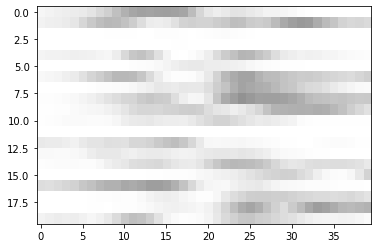

In [32]:
fig,ax = plt.subplots()


ax.imshow(small_mat, cmap='gray_r', aspect='auto', vmin=0, vmax=100)

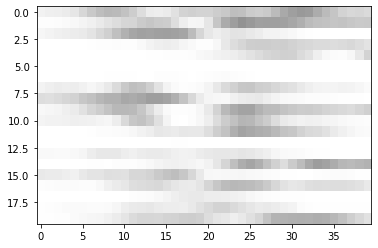

In [33]:
fig,ax = plt.subplots()


ax.imshow(small_mat[hi], cmap='gray_r', aspect='auto', vmin=0, vmax=100)

In [34]:
small.iloc[hi]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id,chrom,start,end,DE_status
121961.0,774.525472,-0.609255,0.176577,-3.450373,5.598115e-04,3.509050e-03,ENSMUSG00000000028,chr16,18811973.0,18811973.0,down
91037.0,2923.142352,-0.476696,0.124516,-3.828409,1.289745e-04,9.999874e-04,ENSMUSG00000000088,chr9,57521273.0,57521273.0,down
29582.0,1929.145607,-0.165139,0.126582,-1.304600,1.920290e-01,3.598572e-01,ENSMUSG00000000001,chr3,108146147.0,108146147.0,nonsig
19787.0,350.865430,-0.131019,0.233169,-0.561905,5.741806e-01,7.335412e-01,ENSMUSG00000000134,chrX,7762559.0,7762559.0,nonsig
131192.0,339.267914,-0.124758,0.223884,-0.557243,5.773614e-01,7.357781e-01,ENSMUSG00000000127,chr17,63863061.0,63863061.0,nonsig
132435.0,9.300054,0.098589,1.223783,0.080560,9.357915e-01,9.664568e-01,ENSMUSG00000000103,chrY,2150347.0,2150347.0,nonsig
68469.0,5.653012,0.144469,1.513693,0.095441,9.239644e-01,NaN,ENSMUSG00000000031,chr7,142578144.0,142578144.0,nonsig
47521.0,27.842053,0.198082,0.833883,0.237541,8.122370e-01,8.976424e-01,ENSMUSG00000000148,chr5,140705010.0,140705010.0,nonsig
66485.0,601.931639,0.211456,0.183019,1.155378,2.479355e-01,4.298352e-01,ENSMUSG00000000131,chr7,126200502.0,126200502.0,nonsig
104720.0,812.764430,0.222758,0.163974,1.358492,1.743076e-01,3.372668e-01,ENSMUSG00000000078,chr13,5861481.0,5861481.0,nonsig


# Testing with: 2020 Liu's dWapl

In [13]:
# data needed from experimental set-up to compare 
proj = "/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/pysradb_downloads/SRP216929/"

# sample 2 condition contains experimental set-up and helps describe the file structure of both kallisto mappings and DESeq results
s2c = pd.read_csv(proj+"s2c.tsv", index_col = 0, sep='\t')

# getting set of possible conditions from the sample 2 condition mapping
conditions = s2c['condition'].unique()

# formatting because dashes were removed when working in R
conditions = [x.strip().replace("-","_") for x in conditions]

# removing PT type for now (treating as a separate experiment)
conditions = [x for x in conditions if 'Wapl' in x ]

In [14]:
# import DEseq results

# base condition
base_level='Wapl_C20_0h'

# Importing the .csv outputs from sleuth WT for each of the conditions into pandas dataframes:
deseq_results = {}

folder = proj+"deseq-mm10-results/"

for c in conditions:
    
    if c == base_level:
        continue
        
    df = pd.read_csv(folder+"pairwise_deseq_wt_"+c+".csv", index_col = 0)
    deseq_results[c] = df


In [15]:
# Import TSS annotations

# Reading gtf file that contains only the parsed TSSes, generated from default gff_utils
tss_df = read_gtf('/project/fudenber_735/genomes/mm10/ensembl/tsses.gtf')

# cleaning out less-well defined chromosome numbers
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('NT_'))]
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('MT'))]

# paste 'chr' to all chromosome names
tss_df["seqname"] = 'chr' + tss_df["seqname"]

# rename column to chrom to match bedframe/bioframe format
tss_df = tss_df.rename(columns= {"seqname" : "chrom"})

# Removing pseudo chromosomes
before = len(tss_df)
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrGL'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrJH'))]
after = len(tss_df)

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'ccds_id']


In [16]:
# drop duplicate TSSes
ts_intervals = tss_df[['gene_id','chrom', 'start', 'end']].drop_duplicates(['gene_id'])

# add a TSS to each gene_id in all the results DFs
for k in deseq_results.keys():
    
    # drop gene from data field if there is no change associated
    deseq_results[k].dropna(subset=['log2FoldChange'], inplace=True)
    #deseq_results[k].set_index('gene_id', inplace=True)
    
    deseq_results[k] = deseq_results[k].merge(ts_intervals, left_index=True, right_on='gene_id', how='left')
    
    # Checking if any of the significant genes will be lost due to loss of TSS annotation
    print("Checking for 'lost' significant genes for condition: ", k)
    ix = np.where(deseq_results[k]['start'].isna() & (deseq_results[k]['padj'] < 0.05))
    print("lost: ", str(deseq_results[k].iloc[ix].shape[0]))
    
    # If could not find a TSS, drop entire row
    deseq_results[k].dropna(subset=['start'], inplace=True)

Checking for 'lost' significant genes for condition:  Wapl_C20_96h
lost:  34
Checking for 'lost' significant genes for condition:  Wapl_C20_48h
lost:  8
Checking for 'lost' significant genes for condition:  Wapl_C20_24h
lost:  1
Checking for 'lost' significant genes for condition:  Wapl_C20_6h
lost:  0


In [17]:
# Load Chip-Seq files 
folder = "/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/chip-seq/"

hr_0 = "GSM3992915_19_WaplC6-0h_antiH3K4me3_sample_calibrated.bw"
hr_6 = "GSM3992916_20_WaplC6-6h_antiH3K4me3_sample_calibrated.bw"
hr_24 = "GSM3992917_21_WaplC6-24h_antiH3K4me3_sample_calibrated.bw"
hr_96 = "GSM3992918_22_WaplC6-96h_antiH3K4me3_sample_calibrated.bw"

In [18]:
chip_seq_condition_dict = {'Wapl_C20_0h' : folder+hr_0, 'Wapl_C20_6h' : folder+hr_6,
                           'Wapl_C20_24h' : folder+hr_24, 'Wapl_C20_96h' : folder+hr_96}

In [19]:
# Testing:
DE_result_df = deseq_results['Wapl_C20_96h']
chip_seq_f = chip_seq_condition_dict['Wapl_C20_24h']

In [20]:
# Testing: generate_signal_matrix
matrix = generate_signal_matrix(chip_seq_f, 
                                DE_result_df['chrom'], 
                                DE_result_df['start'], 
                                DE_result_df['end'], 
                                windowSize=1000, 
                                windowType='extend', 
                                nbins=40)

In [21]:
# label the genes in the results tables with the categories that we're interested in:

# cutoff
pval_cutoff = 0.05
cutoff_col = 'padj'

def label_DE_status_deseq2(gene_row, cutoff_col, pval_cutoff):
    
    cutoff_col = 'padj'
    pval_cutoff = 0.05
    de_value_col = 'log2FoldChange'
    
    if gene_row[cutoff_col] < pval_cutoff:
        if gene_row[de_value_col] < 0:
            return 'down'
        else:
            return 'up'
    return 'nonsig'

DE_result_df['DE_status'] = DE_result_df.apply(lambda row: label_DE_status_deseq2(row), axis=1)

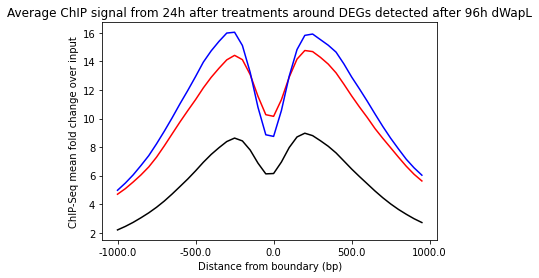

In [22]:
plot_avg_signal(DE_result_df, matrix, 'Average ChIP signal from 24h after treatments around DEGs detected after 96h dWapL', ax=None, 
                DE_value_col='log2FC', cutoff='padj', cutoff_val=0.05, # these can all be deleted I think -- labeling handled outside this function and defined later 
                agg_key='DE_status', agg_categories=['up', 'down', 'nonsig'], color_categories=['r', 'b', 'k'])

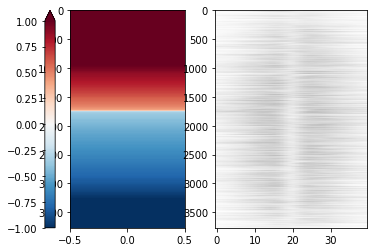

In [88]:
plot_binned_signal_heatmap(DE_result_df, 
                           matrix, 
                           'ChIP signal from 24h after dWapL treatment, DEGs after 96h dWapl',
                           sort_by_DE=True, 
                           agg_key='DE_status', 
                           agg_categories=['up', 'down'],
                           include_category_map=True,
                           color_categories=['r', 'b'])


In [ ]:
## next test: - passing in ax, to get avg signal and heatmap on top of each other

# then: grid-search across conditions for dWapL promoter Chip-signal and DEG gene set